# Статистический анализ данных сервиса по аренде самокатов GoFast

**Описание проекта**

Кикшеринг — это краткосрочная аренда электросамокатов. Это огромная индустрия, которая постоянно развивается. Сервисами аренды электросамокатов в стране в 2023 году пользовалось порядка 21 млн человек. 

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. С помощью данных, полученных с платформы приложения, можно определить зависимости характеритистик друг от друга, выявить аномалии, проверить эффективность промоакций и в итоге определить направления для роста выручки компании.


**Цели проекта:** 

- анализ данных популярного сервиса аренды самокатов GoFast

- проверка гипотез, которые могут помочь бизнесу вырасти

**Ход исследования**

+ Подготовка данных: загрузка и изучение общей информации из предоставленных датасетов 
+ Предобработка данных: обработка пропущенных значений, корректировка типов данных, дубликатов и других аномалий
+ Расширение набора данных: добавление новых столбцов, необходимых для исследования
+ Исследовательский анализ данных: изучение основных параметров объектов, их распределения, зависимостей от раличных характеристик, а также выявление и обработка аномалий
+ Проверка гипотез: вычисление вероятностей отвержения или неотвержения предложенных гипотез
+ Общий вывод: резюмирование полученных результатов, формулировка ключевых выводов.

**Данные:** 

Данные популярного сервиса аренды самокатов GoFast, о некоторых пользователях из нескольких городов, а также об их поездках.

CSV-файлы: 

1. ***Пользователи*** — `users_go.csv`

`user_id` уникальный идентификатор пользователя

`name`	имя пользователя

`age`	возраст

`city`	город

`subscription_type`	тип подписки (free, ultra)

2. ***Поездки*** — `rides_go.csv`

`user_id`	уникальный идентификатор пользователя

`distance`	расстояние, которое пользователь проехал в текущей сессии (в метрах)

`duration`	продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»

`date`	дата совершения поездки

3. ***Подписки*** — `subscriptions_go.csv`

`subscription_type`	тип подписки

`minute_price`	стоимость одной минуты поездки по данной подписке

`start_ride_price`	стоимость начала поездки

`subscription_fee`	стоимость ежемесячного платежа



Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:

**без подписки:**
абонентская плата отсутствует;
стоимость одной минуты поездки — 8 рублей;
стоимость старта (начала поездки) — 50 рублей;

**с подпиской Ultra:**
абонентская плата — 199 рублей в месяц;
стоимость одной минуты поездки — 6 рублей;
стоимость старта — бесплатно.

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
from scipy import stats as st
import warnings
import math
from math import factorial
from math import sqrt
from scipy.stats import binom
from scipy.stats import norm
warnings.filterwarnings('ignore')

# настройка библиотек для графического отображения
import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams, rcParamsDefault

rcParams['figure.figsize'] = 10,5 # устанавливаем размеры фигуры
%config InlineBackend.figure_format = 'svg' # устанавливаем формат изображения как SVG (Scalable Vector Graphics). SVG формат обычно обеспечивает более четкое и качественное изображение графиков.
factor = 0.8 # фактор, который будет использоваться для изменения параметра dpi.
default_dpi = rcParamsDefault['figure.dpi'] # извлекаем значение по умолчанию для точек на дюйм (dpi) из настроек Matplotlib.
rcParams['figure.dpi'] = default_dpi*factor # Эта строка устанавливает разрешение (dpi) для всех фигур. Значение dpi умножается на масштабный фактор, чтобы изменить разрешение в соответствии с предыдущей строкой. Например, если значение factor равно 0.8, то это уменьшит разрешение на 20%.

# настройки отображения
pd.options.display.float_format ='{:,.2f}'.format
pd.set_option('display.max_columns', None)


#### Загрузка данных

In [2]:
# загрузим данные о из csv-файла

try: 
    users = pd.read_csv('/datasets/users_go.csv') 
except: 
    users = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')

try: 
    rides = pd.read_csv('/datasets/rides_go.csv') 
except: 
    rides = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')

try: 
    subscr = pd.read_csv('/datasets/subscriptions_go.csv') 
except: 
    subscr = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')

#### Изучение общей информации о файлах

In [3]:
# изучим общую информацию о файлах, создадим для удобства функцию

def review(data):
    data.info()
    display(data.head(10))

In [4]:
# Информация о пользователях
review(users)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


In [5]:
# Информация о поездках
review(rides)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


,user_id,distance,duration,date
0,1,"4,409.92",25.60,2021-01-01
1,1,"2,617.59",15.82,2021-01-18
2,1,754.16,6.23,2021-04-20
3,1,"2,694.78",18.51,2021-08-11
4,1,"4,028.69",26.27,2021-08-28
5,1,"2,770.89",16.65,2021-10-09
6,1,"3,039.02",14.93,2021-10-19
7,1,"2,842.12",23.12,2021-11-06
8,1,"3,412.69",15.24,2021-11-14
9,1,748.69,15.04,2021-11-22


In [6]:
# Информация о подписке
review(subscr)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


**Предварительный вывод**

Данные о пользователях представлены в датасете на 1565 строк, пропусков нет, типы данных корректные.

Данные о поездках представлены в количестве 18068 записей, без пропусков, столбец даты требует корректировки типа данных.

Данные о подписке демонстрируют стоимость поездок с подпиской и без: стоимость минуты, цену ежемесячной подписки и цену старта.

#### Предобработка данных

##### Изменение типов данных

In [7]:
# приведём столбец `date` в датафрейме с поездками к формату `datetime`

rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')

##### Преобразование данных

In [8]:
# округлим данные в столбце `distance`

rides['distance'] = rides['distance'].round(0)

##### Обработка аномалий

In [9]:
# изучим данные в столбце `duration` на предмет аномалий

rides['duration'].value_counts()

duration
0.50     95
25.60     1
30.93     1
12.06     1
15.62     1
         ..
19.87     1
23.13     1
26.15     1
25.65     1
15.89     1
Name: count, Length: 17974, dtype: int64

Выявлена аномалия: 95 записей поездок в датасете с продолжительностью 0.5 минуты

##### Добавление новых столбцов

Добавим в датафрейм с поездками новый столбец с номером месяца для удобства исследования

In [10]:
# Для этого сначала проверим за какие года информация в датасете о поездках

rides['date'].dt.year.unique()

array([2021], dtype=int32)

Информация представлена за один год, значит можно выделить столбец "месяц"

In [11]:
# добавим в датафрейм с поездками новый столбец с номером месяца для удобства исследования

try:
    rides['month'] = rides['date'].dt.month
except:
    pass

##### Обработка пропущенных значений

In [12]:
# проверим данные на пропуски
display(users.isna().sum())
display(rides.isna().sum())
display(subscr.isna().sum())

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

**Пропуски отсутствуют**

##### Обработка дубликатов

###### Данные о пользователях

In [13]:
# Подсчет явных дубликатов

users.duplicated().sum()

31

In [14]:
# Удаление явных дубликатов

users = users.drop_duplicates().reset_index(drop=True) 
users.duplicated().sum()

0

In [15]:
# Проверим на наличие неявных дубликатов столбец `city`

users['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

###### Данные о поездках

In [16]:
# Подсчет явных дубликатов

rides.duplicated().sum()

0

**Предварительный вывод**

Проведена предобработка данных:
 + Столбец `date` приведен к типу данных `datetime`
 + Выявлена аномалия: 95 записей поездок в датасете с продолжительностью 0.5 минуты
 + Столбец с расстоянием поездки округлен до целого числа
 + Добавлен новый столбец `month` с месяцем поездки
 + Пропусков не обнаружено
 + Выявлены и обработаны явные дубликаты в датасете о пользователях в количестве 31

#### Исследовательский анализ данных

Описание и визуализация общей информации о пользователях и поездках

##### Частота встречаемости городов

In [17]:
# Изучим как часто встречаются те или иные города в датасете

users['city'].value_counts()

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: count, dtype: int64

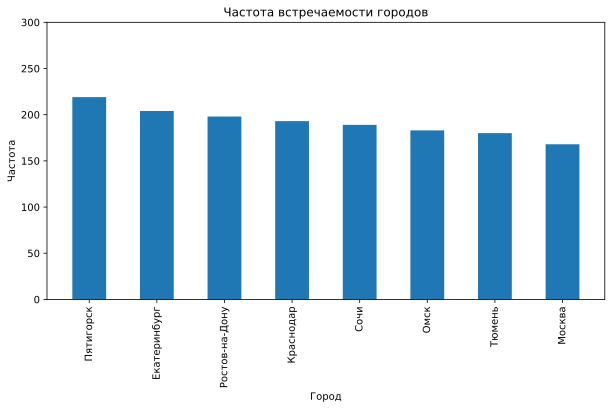

In [18]:
# Построим столбчатую диаграмму для наглядности

city = users['city'].value_counts()
plt.bar(city.index, city.values, width=0.5);
plt.xlabel('Город')
plt.ylim(0, 300)
plt.xticks(rotation=90)
plt.ylabel('Частота')
plt.title('Частота встречаемости городов')
plt.show()

**Предварительный вывод:**

В нашей выборке представлены данные пользователей из 8 городов:

в порядке убывания количества пользователей
- Пятигорск
- Екатеринбург
- Ростов-на-Дону
- Краснодар
- Сочи
- Омск
- Тюмень
- Москва

##### Соотношение пользователей с подпиской и без подписки

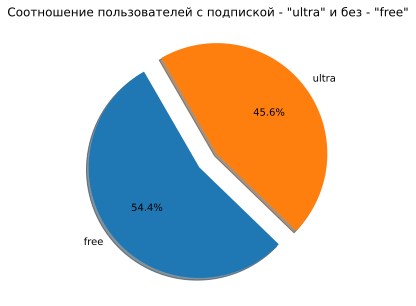

In [19]:
# Построим круговую диаграмму для наглядности долей

subscription = users.groupby('subscription_type')['user_id'].count()
plt.pie(subscription, labels=subscription.index, autopct='%1.1f%%', explode=(0.1, 0.1), startangle=120, shadow=True);
plt.title('Соотношение пользователей с подпиской - "ultra" и без - "free"')
plt.show()

**Предварительный вывод:**

Пользователей, которые не пользуются платной подпиской, на 4.5% больше, чем тех, кто пользуется ей ежемесячно.

##### Возраст пользователей

In [20]:
# Посмотрим описание столбца `age`

users['age'].describe()

count   1,534.00
mean       24.90
std         4.57
min        12.00
25%        22.00
50%        25.00
75%        28.00
max        43.00
Name: age, dtype: float64

Представлены данные по пользователям со средним возрастом 25 лет, минимальный возраст - 12 лет, максимальный - 43 года

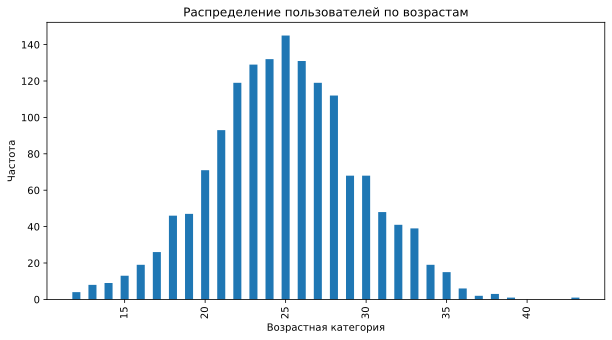

In [21]:
# Визуализация 

age = users['age'].value_counts()
plt.bar(age.index, age.values, width=0.5);
plt.xlabel('Возрастная категория')
plt.xticks(rotation=90)
plt.ylabel('Частота')
plt.title('Распределение пользователей по возрастам')
plt.show()

**Предварительный вывод:**

Большую часть в нашей выборке  - более 70% , занимают пользователи возраста с 20 до 30 лет.

##### Расстояние, которое пользователь преодолел за одну поездку

In [22]:
# Посмотрим описание столбца `distance`

rides['distance'].describe()

count   18,068.00
mean     3,070.66
std      1,116.83
min          1.00
25%      2,543.00
50%      3,134.00
75%      3,776.00
max      7,211.00
Name: distance, dtype: float64

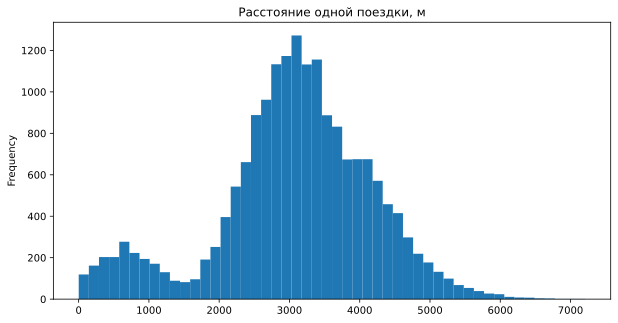

In [23]:
# Построим столбчатую диаграмму для наглядности

rides['distance'].plot(kind='hist', bins=50, title='Расстояние одной поездки, м');

**Предварительный вывод:**

В среднем расстояние каждой поездки составляет 3 км. Минимальное расстояние равно 1 м, максимальное расстояние 7 км.

##### Продолжительность поездок

In [24]:
# Посмотрим описание столбца `duration`

rides['duration'].describe()

count   18,068.00
mean        17.81
std          6.09
min          0.50
25%         13.60
50%         17.68
75%         21.72
max         40.82
Name: duration, dtype: float64

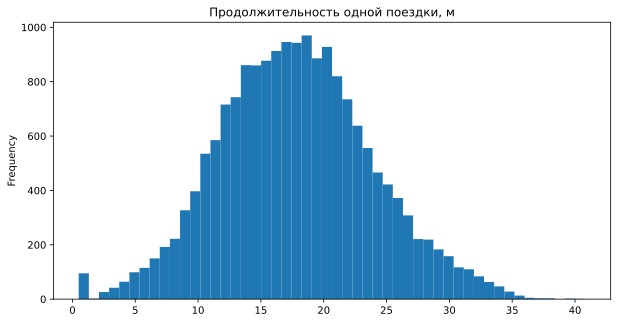

In [25]:
# Построим столбчатую диаграмму для наглядности

rides['duration'].plot(kind='hist', bins=50, title='Продолжительность одной поездки, м');

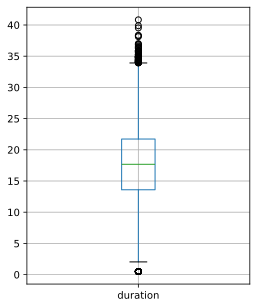

In [26]:
# Посмотрим на данные по диаграмме размаха

rides.boxplot(column='duration', figsize=(4,5));

**Предварительный вывод:**

В среднем продолжительность каждой поездки составляет 18 минут. Минимальная продолжительность равна 0.5 минуты, максимальная - 41 минута.

#### Объединение данных

In [27]:
# Объединим датафреймы о пользователях и поездках в один, используя метод `merge`

merged_df = pd.merge(users, rides, on='user_id', how='right')
merged_df.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,"4,410.00",25.60,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,"2,618.00",15.82,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,754.00,6.23,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,"2,695.00",18.51,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,"4,029.00",26.27,2021-08-28,8


In [28]:
# Проверим не появились ли пропуски

merged_df.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
dtype: int64

In [29]:
# Объединим датафрейм с данными о подписке, используя метод `merge`

total_df = pd.merge(merged_df, subscr, on='subscription_type', how='left')
total_df.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,"4,410.00",25.60,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,"2,618.00",15.82,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.00,6.23,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,"2,695.00",18.51,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,"4,029.00",26.27,2021-08-28,8,6,0,199


In [30]:
# Объединим датафрейм с данными о подписке, используя метод `merge`

total_df = pd.merge(merged_df, subscr, on='subscription_type', how='left')
total_df.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,"4,410.00",25.60,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,"2,618.00",15.82,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.00,6.23,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,"2,695.00",18.51,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,"4,029.00",26.27,2021-08-28,8,6,0,199


In [31]:
# Создадим датафреймы с данными о пользователях с подпиской и без нее:

df_subscr = total_df.query('subscription_type == "ultra"')
df_free = total_df.query('subscription_type == "free"')


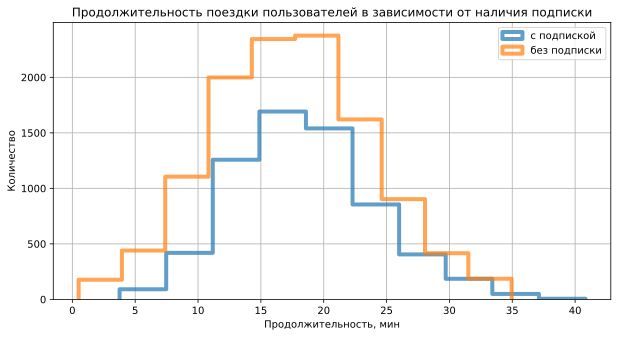

In [32]:
# Визуализируем продолжительность поездки для пользователей с подпиской и без:

df_subscr['duration'].plot(kind='hist', histtype='step', linewidth=4, label='с подпиской', alpha=0.7)
df_free['duration'].plot(kind='hist', histtype='step', linewidth=4, label='без подписки', alpha=0.7)

plt.ylabel('Количество')
plt.xlabel('Продолжительность, мин')
plt.title(f'Продолжительность поездки пользователей в зависимости от наличия подписки')
plt.grid(True)
plt.legend()
plt.show()


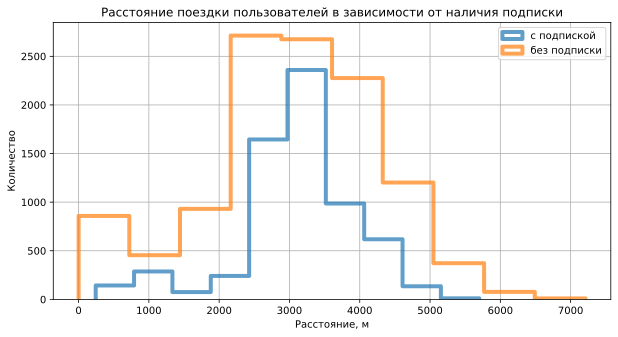

In [33]:
# Визуализируем расстояние поездок для пользователей с подпиской и без:

df_subscr['distance'].plot(kind='hist', histtype='step', linewidth=4, label='с подпиской', alpha=0.7)
df_free['distance'].plot(kind='hist', histtype='step', linewidth=4, label='без подписки', alpha=0.7)

plt.ylabel('Количество')
plt.xlabel('Расстояние, м')
plt.title(f'Расстояние поездки пользователей в зависимости от наличия подписки')
plt.grid(True)
plt.legend()
plt.show()


In [34]:
# Сделаем сводную таблицу по средним и медианным значениям расстояния и продолжительности поездки 
# в зависимости от наличия подписки

total_df_pivot = total_df.pivot_table(
    index='subscription_type', 
    values=['duration', 'distance'], 
    aggfunc={'duration': ['mean', 'median'], 'distance':['mean', 'median']}
)
total_df_pivot = total_df_pivot.rename(columns = {'mean': 'Среднее', 'median': 'Медиана', 'distance': 'Расстояние', 'duration': 'Продолжительность'})

total_df_pivot

Расстояние          Продолжительность        
                     Среднее  Медиана           Среднее Медиана
subscription_type                                              
free                3,045.49 3,115.00             17.39   17.33
ultra               3,115.44 3,149.00             18.54   18.18

**Предварительный вывод:**

Большинство поездок пользователей с подпиской продолжительностью от 11 до 26 минут.
Когда как пользователи без подписки в большинстве совершают поездки продолжительностью от 9 до 25 минут.
Также заметно, что пользователи с подпиской склонны к более долгим поездкам свыше 40 минут, когда как самая долгая поездка у пользователя без подписки 35 минут.

Что касается расстояния поездок, то пользователи с подпиской в большинстве совершают поездки на расстояние от 2.5 км до 4.5 км. Пользователи без подписки в большинстве совершали поездки на расстояние от 1.5 км до 5 км, а также очень малые по расстоянию поездки - от 300 до 900 метров, у пользователей с подпиской таких поездок гораздо меньше.

#### Подсчёт выручки

In [35]:
# Найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц:

pivot_revenue = total_df.pivot_table(
    index=['user_id', 'month'], 
    aggfunc={'date':'count', 
             "distance": 'sum', 
             "duration": 'sum', 
             'subscription_type': 'last',
             'start_ride_price': 'mean', 
             'minute_price': 'mean', 
             'subscription_fee': 'mean'}
).reset_index()
pivot_revenue = pivot_revenue.rename(columns = {'date': 'count'})
pivot_revenue['duration'] = pivot_revenue['duration'].apply(lambda x: math.ceil(x))
pivot_revenue

,user_id,month,count,distance,duration,minute_price,start_ride_price,subscription_fee,subscription_type
0,1,1,2,"7,028.00",42,6.00,0.00,199.00,ultra
1,1,4,1,754.00,7,6.00,0.00,199.00,ultra
2,1,8,2,"6,724.00",45,6.00,0.00,199.00,ultra
3,1,10,2,"5,810.00",32,6.00,0.00,199.00,ultra
4,1,11,3,"7,004.00",54,6.00,0.00,199.00,ultra
...,...,...,...,...,...,...,...,...,...
11326,1534,6,2,"3,409.00",25,8.00,50.00,0.00,free
11327,1534,8,2,"7,623.00",48,8.00,50.00,0.00,free
11328,1534,9,1,"4,928.00",23,8.00,50.00,0.00,free
11329,1534,11,4,"13,349.00",77,8.00,50.00,0.00,free


In [36]:
# Посчитаем выручку для каждого пользователя по месяцам:

pivot_revenue['revenue'] = pivot_revenue['start_ride_price'] * pivot_revenue['count'] + pivot_revenue['duration'] * pivot_revenue['minute_price'] + pivot_revenue['subscription_fee']
pivot_revenue

,user_id,month,count,distance,duration,minute_price,start_ride_price,subscription_fee,subscription_type,revenue
0,1,1,2,"7,028.00",42,6.00,0.00,199.00,ultra,451.00
1,1,4,1,754.00,7,6.00,0.00,199.00,ultra,241.00
2,1,8,2,"6,724.00",45,6.00,0.00,199.00,ultra,469.00
3,1,10,2,"5,810.00",32,6.00,0.00,199.00,ultra,391.00
4,1,11,3,"7,004.00",54,6.00,0.00,199.00,ultra,523.00
...,...,...,...,...,...,...,...,...,...,...
11326,1534,6,2,"3,409.00",25,8.00,50.00,0.00,free,300.00
11327,1534,8,2,"7,623.00",48,8.00,50.00,0.00,free,484.00
11328,1534,9,1,"4,928.00",23,8.00,50.00,0.00,free,234.00
11329,1534,11,4,"13,349.00",77,8.00,50.00,0.00,free,816.00


#### Проверка гипотез

##### Проверка гипотезы: "Пользователи с подпиской тратят больше времени на поездки"

Тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании.

Сформирулируем гипотезы:

Нулевая гипотеза: Продолжительности поездок пользователей с подпиской и без нее равны.

Альтернативная гипотеза: Пользователи с подпиской тратят больше времени на поездки.

In [37]:
# Возьмем данные о продолжительности поездки пользователей с подпиской и без нее

duration_ultra = df_subscr['duration'].tolist()
duration_free = df_free['duration'].tolist()

# Установим уровень статзначимости 5 %
alpha = 0.05

# Проверим t-тестом нулевую гипотезу о равенстве и альтернативную о том, 
# что у пользователей с подпиской продолжительность поездки больше

results = st.ttest_ind(duration_ultra, duration_free, alternative='greater')

# Выведем значение p-value
print('p-значение:', results.pvalue)

# Получим вывод об отвержении или неотвержении нулевой гипотезы
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


**Предварительный вывод:**

Опираясь на вывод двухвыборочного t-теста для независимых выборок, можно сказать, что действительно, пользователи с подпиской тратят больше времени на поездки.

##### Проверка гипотезы: "Подписчики в среднем проезжают расстояние больше оптимального"

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

Сформирулируем гипотезы:

Нулевая гипотеза: Среднее расстояние поездок пользователей с подпиской равно оптимальному.

Альтернативная гипотеза: Пользователи с подпиской проезжают в среднем расстояние больше оптимального.

In [38]:
# Возьмем данные о дистанции поездки пользователей с подпиской

distance_ultra = df_subscr['distance'].tolist()

# Предполагаемое в нулевой гипотезе число
value = 3130

# Установим уровень статзначимости 5 %
alpha = 0.05

# Проверим t-тестом нулевую гипотезу о равенстве среднего значения дистанции 3130 м и альтернативную о том, 
# что этот показатель более 3130 м

results = st.ttest_1samp(distance_ultra, value, alternative='greater')

# Выведем значение p-value
print('p-значение:', results.pvalue)

# Получим вывод об отвержении или неотвержении нулевой гипотезы
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.9195649894697724
Не получилось отвергнуть нулевую гипотезу


**Предварительный вывод:**

Согласно результату одновыборочного t-теста, пользователи с подпиской  в среднем проезжают расстояние не более оптимального.

##### Проверка гипотезы: "Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки"

Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Сформирулируем гипотезы:

Нулевая гипотеза: Помесячная выручка от пользователей с подпиской равна выручке от пользователей без подписки.

Альтернативная гипотеза: Помесячная выручка от пользователей с подпиской больше выручки от пользователей без подписки.

In [39]:
# Возьмем данные о помесячной выручке от пользователей с подпиской и без нее

pivot_revenue_ultra = pivot_revenue.query('subscription_fee != 0')
pivot_revenue_free = pivot_revenue.query('subscription_fee == 0')

revenue_ultra = pivot_revenue_ultra['revenue'].tolist()
revenue_free = pivot_revenue_free['revenue'].tolist()

print(f'Средняя помесячная выручка пользователей с подпиской: {np.mean(revenue_ultra)}')
print(f'Средняя помесячная выручка пользователей без подписки: {np.mean(revenue_free)}')

# Установим уровень статзначимости 5 %
alpha = 0.05

# Проверим t-тестом нулевую гипотезу о равенстве и альтернативную о том, 
# что у пользователей с подпиской помесячная выручка больше

results = st.ttest_ind(revenue_ultra, revenue_free, alternative='greater')

# Выведем значение p-value
print('p-значение:', results.pvalue)

# Получим вывод об отвержении или неотвержении нулевой гипотезы
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Средняя помесячная выручка пользователей с подпиской: 361.48180013236265
Средняя помесячная выручка пользователей без подписки: 325.84289496910856
p-значение: 2.8130926188487286e-35
Отвергаем нулевую гипотезу


**Предварительный вывод:**

Опираясь на вывод двухвыборочного t-теста для независимых выборок, можно сказать, что действительно, пользователи с подпиской приносят больше помесячной  средней выручки.

##### Проверка гипотезы: "Количество обращений в техподдержку значимо снизилось после обновления серверов приложения"

Техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

**Предварительный вывод:**

Для проверки такого рода гипотезы подойдет двухвыборочный t-тест для зависимых выборок, метод ttest_ind

#### Распределения

##### Задача  с промокодами

 Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

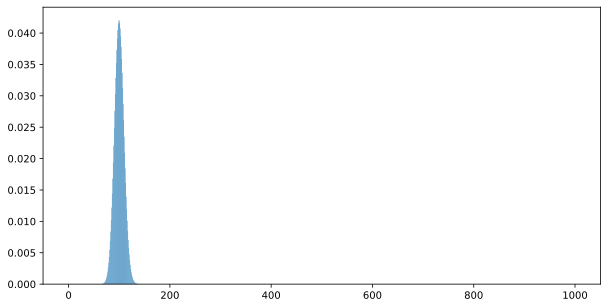

In [40]:
# Построим биномиальное распределение для 1000 разосланных промокодов
p = 0.1
n = 1000

distr = []

for k in range(0, n + 1):
    current_value = binom.pmf(k, n, p)
    distr.append(current_value)
    
plt.bar(range(0, n + 1), distr);

С количеством разосланных промокодов равным 1000, вероятность, что 100 пользователей продлят подписку равна 50%. Нам необходимо не менее 95%. Попробуем увеличить количество промокодов.

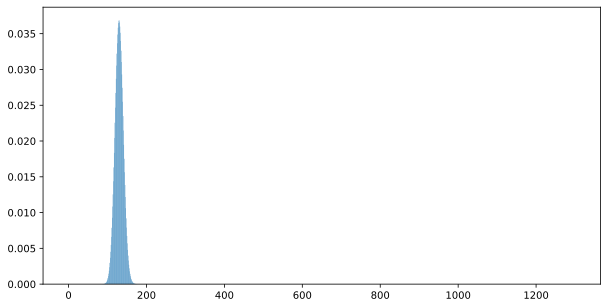

In [41]:
# Построим биномиальное распределение для 1300 разосланных промокодов
p = 0.1
n = 1300

distr = []

for k in range(0, n + 1):
    current_value = binom.pmf(k, n, p)
    distr.append(current_value)
    
plt.bar(range(0, n + 1), distr);

In [42]:
# Построим для неё аппроксимацию нормальным распределением

# параметры биномиального распределения
n = 1170
p = 0.1

mu = n * p
sigma = sqrt(n * p * (1-p))

# задаем нормальное распределение
distr = st.norm(mu, sigma)

# находим вероятность получить менее 100 новых подписчиков
result = distr.cdf(100)
print(result)

0.04879359652776027


**Предварительный вывод:**

Потребуется разослать не менее 1170 промокодов, чтобы получить не менее 100 подписчиков с вероятностью около 5%.

##### Задача  с push-уведомлениями

 Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

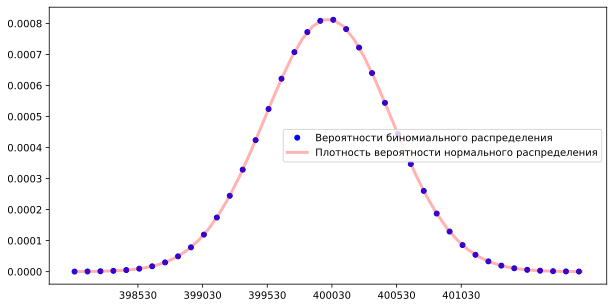

Условие выполняется


In [43]:
# Построим график биномиального распределения и 
# проверим условия аппроксимации биномиального распределения нормальным

n = 1000000
p = 0.4

mu = n * p
sigma = sqrt(n * p * (1-p))


# Строим график биномиального распределения:

left = int(n * p - 4 * sqrt(n * p * (1 - p)))
right = int(n * p + 4 * sqrt(n * p * (1 - p)))

x = list(range(max(0, left), right, 100))
ax = plt.subplot()
ax.plot(x, binom.pmf(x, n, p), 'bo', ms=5, label='Вероятности биномиального распределения')

# Строим график нормального распределения:

def linspace(start, stop, num):
    step = (stop - start) / (num - 1)
    result = []
    for i in range(num):
        result.append(start + step * i)
    return result

x = linspace(left, right, 50)
ax.plot(x, norm.pdf(x, mu, sigma), 'r-', lw=3, alpha=0.3, label='Плотность вероятности нормального распределения')

# зададим подписи по оси x в пределах ± 3 ст.отклонений от мат.ожидания
x_ticks = list(range(int(mu - 3 * sigma), int(mu + 3 * sigma), 500))
ax.set_xticks(x_ticks)

ax.legend(loc='best')
plt.show()

# выводим, выполняется ли наше условие аппроксимации:
# лежит ли mu ± 3 sigma в промежутке от 0 до n:
if (mu - (3 * sigma) >= 0) and ((mu + (3 * sigma) <= n)):
    print('Условие выполняется')
else:
    print('Условие не выполняется')

In [44]:
# Найдем вероятность

# параметры биномиального распределения
n = 1000000
p = 0.4

# параметры нормального распределения
mu = n * p
sigma = sqrt(n * p * (1-p))

# задаем нормальное распределение
distr = st.norm(mu, sigma)

# находим вероятность получить менее 399.5 тыс новых подписчиков
result = round(distr.cdf(399500) * 100, 2)
print('Вероятность того, что уведомление откроют не более 399.5 тыс пользователей:', result)

Вероятность того, что уведомление откроют не более 399.5 тыс пользователей: 15.37


**Предварительный вывод:**

Вероятность получить менее 399500 новых подписчиков в результате 1 млн. разосланных уведомлений равна 15 %

#### Общий вывод

##### Входные данные

Данные популярного сервиса аренды самокатов  GoFast.

##### Цель проекта:

1. Анализ данных о пользователях и их поездках на самокатах в зависимости от наличия или отсутствия подписки


2. Проверка гипотез: 

 - "Пользователи с подпиской тратят больше времени на поездки"
 - "Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, превышает оптимальное 3130 метров"
 - "Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки"¶

##### Ход исследования:


**Предобработка данных**

Данные были изучены на предмет пригодности к анализу.

***Изменение типов данных*** 

Столбец `date` в данных с поездками приведен к формату `datetime`

Данные в столбце `distance` округлены до целого числа

***Пропуски*** 

Пропусков не выявлено.

***Дубликаты***

Выявлено и обработано 31 явных дубликатов. 

***Добавление новых столбцов***

В данные с поездками добавлен новый столбец с номером месяца для удобства исследования

***Аномальные значения***

В данных о поездках было обнаружено 95 аномальных значений продолжительности поездки по 0.5 минуты

**Исследовательский анализ**


***1. Частота встречаемости городов***

Представлены данные пользователей из 8 городов в порядке убывания количества поездок:
- Пятигорск
- Екатеринбург
- Ростов-на-Дону
- Краснодар
- Сочи
- Омск
- Тюмень
- Москва


***2. Соотношение пользователей с подпиской и без подписки***

Пользователей, которые не пользуются платной подпиской, на 4.5% больше, чем тех, кто пользуется ей ежемесячно.

***3. Возраст пользователей***

Большую часть данных  - более 70% , занимает информация о пользователях от 20 до 30 лет.


***4. Расстояние, которое пользователь преодолел за одну поездку***

В среднем расстояние каждой поездки составляет 3 км. Минимальное расстояние равно 1 м, максимальное расстояние 7 км.

***5. Продолжительность поездок***

В среднем продолжительность каждой поездки составляет 18 минут. Минимальная продолжительность равна 0.5 минуты, максимальная - 41 минута.


**Объединение данных**

Для объединения выбран метод `.merge`. Были объединены данные трех источников: данные о пользователях и о поездках по ключу `user_id`, затем добавлены данные с параметрами подписки по ключу `subscription_type`. 

Визуализированы данные с продолжительностью и расстоянием поездки для пользователей с подпиской и без. 

Опираясь на график, сделаны следующие выводы:
 + Большинство поездок пользователей с подпиской продолжительностью от 11 до 26 минут, когда как пользователи без подписки в большинстве совершают поездки продолжительностью от 9 до 25 минут.
 + Пользователи с подпиской склонны к более долгим поездкам свыше 40 минут, когда как самая долгая поездка у пользователя без подписки 35 минут.

 + Пользователи с подпиской в большинстве совершают поездки на расстояние от 2.5 км до 4.5 км. 
 + Пользователи без подписки в большинстве совершают поездки на расстояние от 1.5 км до 5 км, а также очень малые по расстоянию поездки - от 300 до 900 метров, у пользователей с подпиской таких поездок гораздо меньше.
 
**Подсчет выручки**
 
 Сформирована сводная таблица с данными по выручке для каждого пользователя по месяцам.
 
**Проверка гипотез**

1. "Пользователи с подпиской тратят больше времени на поездки"

Опираясь на вывод двухвыборочного t-теста для независимых выборок, можно сказать, что действительно, пользователи с подпиской тратят больше времени на поездки.

2. "Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает оптимального 3130 м"

Согласно результату одновыборочного t-теста, пользователи с подпиской  в среднем проезжают расстояние не более оптимального.

3. "Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки"

Опираясь на вывод двухвыборочного t-теста для независимых выборок, можно сказать, что пользователи с подпиской более "выгоднее"

4. "Количество обращений в техподдержку значимо снизилось после обновления серверов приложения"

Для проверки такого рода гипотезы подойдет двухвыборочный t-тест для зависимых выборок, метод `ttest_ind`

В данном случае будем проверять одностороннюю гипотезу.

    Нулевая: среднее количество обращений до и после обновления равны
    Альтернативная: правосторонняя гипотеза, о том, что до обновления среднее количество обращений было больше, чем после.

**Распределения**

1. Задача с промокодами

Потребуется разослать не менее 1170 промокодов, чтобы получить не менее 100 подписчиков с вероятностью около 5%.

2. Задача с push-уведомлениями

Вероятность получить менее 399500 новых подписчиков в результате 1 млн. разосланных уведомлений равна 15 %

**Рекомендации для рекламного отдела**

Для получения большей выручки компании рационально запустить продвижение подписки `ultra` 